<a href="https://colab.research.google.com/github/s1111e/ComputerVision/blob/main/Object_Detection_On_KITTI_Detection_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OBJECT DETECTION

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# dataset paths
import os

BASE_DIR = "/content/drive/My Drive/Colab Notebooks/CV Project/Data/kitti"

IMAGE_DIR = os.path.join(BASE_DIR, "training/image_2")
LABEL_DIR = os.path.join(BASE_DIR, "training/label_2")

print("KITTI image dir:", IMAGE_DIR)
print("KITTI label dir:", LABEL_DIR)


KITTI image dir: /content/drive/My Drive/Colab Notebooks/CV Project/Data/kitti/training/image_2
KITTI label dir: /content/drive/My Drive/Colab Notebooks/CV Project/Data/kitti/training/label_2


In [ ]:
#3. Load KITTI label (KITTI format parser)
def load_kitti_label_file(label_path):
    """
    Returns a list of objects:
    [{"class": class_name, "bbox": [x1,y1,x2,y2]}]
    """
    objects = []
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()

            cls = parts[0]     # Car, Pedestrian, Cyclist, etc.
            x1 = float(parts[4])
            y1 = float(parts[5])
            x2 = float(parts[6])
            y2 = float(parts[7])

            objects.append({
                "class": cls,
                "bbox": [x1, y1, x2, y2]
            })

    return objects


In [ ]:
#Test label parsing on one example
label_path = os.path.join(LABEL_DIR, "000000.txt")
ann = load_kitti_label_file(label_path)

ann[:5]  # print first 5 objects in first image


[{'class': 'Pedestrian', 'bbox': [712.4, 143.0, 810.73, 307.92]}]

Text(0.5, 1.0, '006110.png')

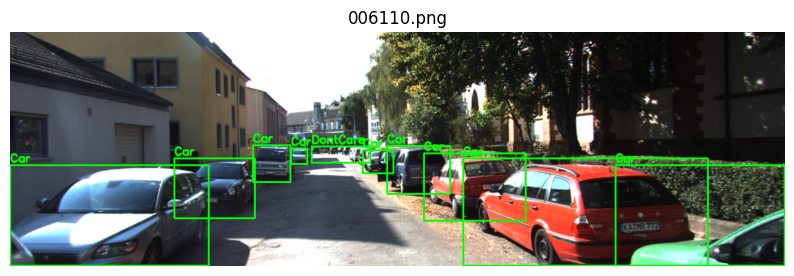

In [ ]:
#Visualize bounding boxes
import cv2
import matplotlib.pyplot as plt

def draw_kitti_boxes(img, objects):
    img = img.copy()
    for obj in objects:
        x1,y1,x2,y2 = map(int, obj["bbox"])
        cv2.rectangle(img, (x1,y1), (x2,y2), (0,255,0), 2)
        cv2.putText(img, obj["class"], (x1, y1-5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6,
                    (0,255,0), 2)
    return img



import random

all_images = sorted(os.listdir(IMAGE_DIR))
img_name = random.choice(all_images)

img_path = os.path.join(IMAGE_DIR, img_name)
label_path = os.path.join(LABEL_DIR, img_name.replace(".png", ".txt"))

img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

labels = load_kitti_label_file(label_path)
img_vis = draw_kitti_boxes(img_rgb, labels)

plt.figure(figsize=(10,5))
plt.imshow(img_vis)
plt.axis("off")
plt.title(img_name)


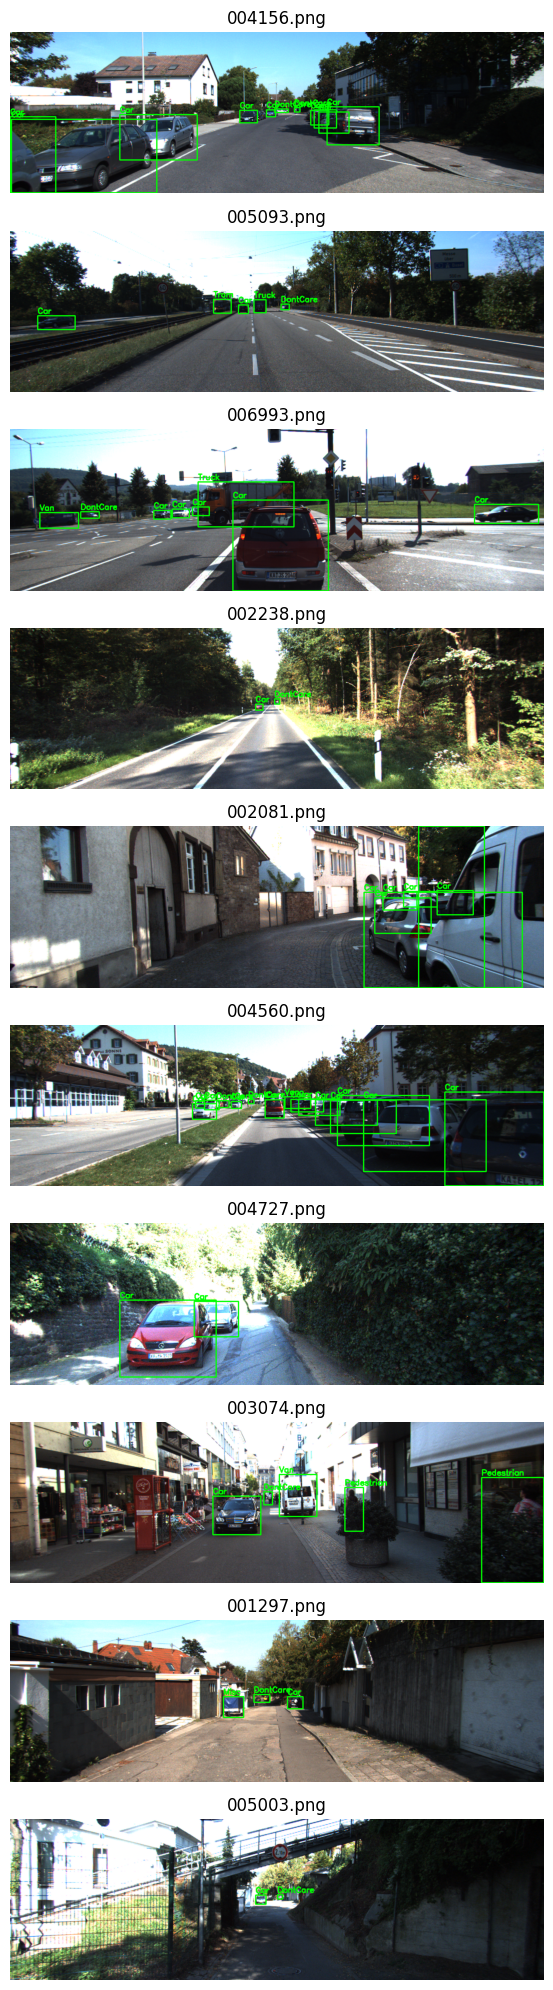

In [ ]:
#Show 10 random samples (side-by-side)

def show_random_kitti_samples(n=10):
    samples = random.sample(all_images, n)
    plt.figure(figsize=(20, 2*n))

    for idx, imname in enumerate(samples):
        img_path = os.path.join(IMAGE_DIR, imname)
        label_path = os.path.join(LABEL_DIR, imname.replace(".png", ".txt"))

        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        objs = load_kitti_label_file(label_path)
        img_vis = draw_kitti_boxes(img_rgb, objs)

        plt.subplot(n, 1, idx+1)
        plt.imshow(img_vis)
        plt.title(imname)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

show_random_kitti_samples(10)


In [ ]:
#Train/Val Split %80 train %20 val
import random

all_images = sorted(os.listdir(IMAGE_DIR))
random.shuffle(all_images)

train_ratio = 0.8
train_count = int(len(all_images) * train_ratio)

train_files = all_images[:train_count]
val_files = all_images[train_count:]

print("Train images:", len(train_files))
print("Val images:", len(val_files))


Train images: 5984
Val images: 1497


# Convert KITTI Labels → YOLO Format

In [ ]:
YOLO_DATASET = "/content/drive/My Drive/Colab Notebooks/CV Project/Data/kitti_yolo"

In [ ]:
#Class Map
CLASS_MAP = {
    "Car": 0,
    "Pedestrian": 1,
    "Cyclist": 2
}

VALID_CLASSES = set(CLASS_MAP.keys())

#YOLO Dataset Folder

import os
import shutil

YOLO_DATASET = "/content/drive/My Drive/Colab Notebooks/CV Project/Data/kitti_yolo"

dirs = [
    f"{YOLO_DATASET}/images/train",
    f"{YOLO_DATASET}/images/val",
    f"{YOLO_DATASET}/labels/train",
    f"{YOLO_DATASET}/labels/val",
]

for d in dirs:
    os.makedirs(d, exist_ok=True)

print("YOLO dataset folder ready:", YOLO_DATASET)

#KITTI → YOLO Label
def kitti_to_yolo_bbox(bbox, img_w, img_h):
    x1, y1, x2, y2 = bbox
    bw = x2 - x1
    bh = y2 - y1
    cx = x1 + bw / 2
    cy = y1 + bh / 2

    return [
        cx / img_w,
        cy / img_h,
        bw / img_w,
        bh / img_h
    ]



import cv2

def convert_kitti_to_yolo_split(split_files, split_name):
    for img_name in split_files:

        img_path = os.path.join(IMAGE_DIR, img_name)
        label_path = os.path.join(LABEL_DIR, img_name.replace(".png", ".txt"))

        # copy image
        out_img_path = os.path.join(YOLO_DATASET, "images", split_name, img_name)
        shutil.copy(img_path, out_img_path)

        # image size
        img = cv2.imread(img_path)
        h, w = img.shape[:2]

        # load KITTI labels
        objs = load_kitti_label_file(label_path)

        # create YOLO label file
        out_label_path = os.path.join(YOLO_DATASET, "labels", split_name, img_name.replace(".png", ".txt"))

        with open(out_label_path, "w") as f:
            for obj in objs:
                cls = obj["class"]
                if cls not in VALID_CLASSES:
                    continue

                yolo_cls = CLASS_MAP[cls]
                yolo_box = kitti_to_yolo_bbox(obj["bbox"], w, h)

                f.write(f"{yolo_cls} " + " ".join(f"{v:.6f}" for v in yolo_box) + "\n")



YOLO dataset folder ready: /content/drive/My Drive/Colab Notebooks/CV Project/Data/kitti_yolo


In [ ]:
convert_kitti_to_yolo_split(train_files, "train")
convert_kitti_to_yolo_split(val_files, "val")

print("Conversion completed!")


Conversion completed!


In [ ]:
# yaml

data_yaml = f"""
train: {YOLO_DATASET}/images/train
val: {YOLO_DATASET}/images/val

nc: 3
names: ["Car", "Pedestrian", "Cyclist"]
"""

with open(f"{YOLO_DATASET}/data.yaml", "w") as f:
    f.write(data_yaml)

print(data_yaml)



train: /content/drive/My Drive/Colab Notebooks/CV Project/Data/kitti_yolo/images/train
val: /content/drive/My Drive/Colab Notebooks/CV Project/Data/kitti_yolo/images/val

nc: 3
names: ["Car", "Pedestrian", "Cyclist"]



In [ ]:
# install Ultralytics

!pip install ultralytics
from ultralytics import YOLO


#COCO pretrained
model = YOLO("yolo11s.pt")







In [ ]:
model.train(
    data=f"{YOLO_DATASET}/data.yaml",
    epochs=10,
    imgsz=640,
    batch=16,
    workers=2,
    lr0=0.001,
    pretrained=True,
    optimizer="Adam",
    project="/content/drive/My Drive/Colab Notebooks/CV Project/trained_models",
    name="yolo11_kitti",
    exist_ok=True
)

Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/My Drive/Colab Notebooks/CV Project/Data/kitti_yolo/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo11_kitti, nbs=64, nms=False, opset=None, optimize=False, optimizer=Adam, overlap_mask=

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f125df3ebd0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

In [ ]:
#Validation
model.val(data=f"{YOLO_DATASET}/data.yaml")


Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
YOLO11s summary (fused): 100 layers, 9,413,961 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 325.2±84.6 MB/s, size: 800.1 KB)
val: Scanning /content/drive/My Drive/Colab Notebooks/CV Project/Data/kitti_yolo/labels/val.cache... 1497 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1497/1497 1.9Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 94/94 5.5it/s 17.2s
                   all       1497       7102      0.897      0.793      0.876      0.615
                   Car       1345       5783      0.925      0.917      0.962      0.799
            Pedestrian        368       1005       0.88      0.683       0.81      0.459
               Cyclist        231        314      0.887       0.78      0.856      0.588
Speed: 0.3ms preprocess, 1.1ms inference, 0.0ms loss, 0.8ms postprocess

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7954bdd960c0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

In [ ]:
!pip install ultralytics
from ultralytics import YOLO



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.5 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:

#inference test with best weight
model = YOLO("/content/drive/My Drive/Colab Notebooks/CV Project/trained_models/yolo11_kitti/weights/best.pt")
result = model(IMAGE_DIR + "/000123.png", show=True)

WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()


image 1/1 /content/drive/My Drive/Colab Notebooks/CV Project/Data/kitti/training/image_2/000123.png: 224x640 1 Car, 370.0ms
Speed: 12.6ms preprocess, 370.0ms inference, 34.7ms postprocess per image at shape (1, 3, 224, 640)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# New Section

In [ ]:
#PyTorch KITTI Dataloader
import os
import cv2
import torch
import random
import numpy as np
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

#KITTI → torch format helper
CLASS_MAP = {
    "Car": 1,
    "Pedestrian": 2,
    "Cyclist": 3
}
VALID_CLASSES = set(CLASS_MAP.keys())


#transform pipelines

#Training augmentations:
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.MotionBlur(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.02, scale_limit=0.2, rotate_limit=5, p=0.5),
    A.Resize(640, 640),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))


#Validation, no augmentations
val_transform = A.Compose([
    A.Resize(640, 640),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))


In [ ]:
#Custom KITTI Dataset Class

class KITTIDataset(Dataset):
    def __init__(self, image_dir, label_dir, file_list, transforms=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transforms = transforms
        self.file_list = file_list

    def load_kitti_label(self, label_path):
        objects = []
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                cls = parts[0]
                if cls not in VALID_CLASSES:
                    continue

                x1 = float(parts[4])
                y1 = float(parts[5])
                x2 = float(parts[6])
                y2 = float(parts[7])

                objects.append({
                    "class": CLASS_MAP[cls],
                    "bbox": [x1, y1, x2, y2]
                })
        return objects

    def __getitem__(self, idx):
        img_name = self.file_list[idx]
        img_path = os.path.join(self.image_dir, img_name)
        label_path = os.path.join(self.label_dir, img_name.replace(".png", ".txt"))

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        h, w, _ = img.shape

        objects = self.load_kitti_label(label_path)

        boxes = []
        labels = []

        for obj in objects:
            x1,y1,x2,y2 = obj["bbox"]
            if x2 <= x1 or y2 <= y1:
                continue

            boxes.append([x1, y1, x2, y2])
            labels.append(obj["class"])

        boxes = np.array(boxes)
        labels = np.array(labels)

        if self.transforms:
            transformed = self.transforms(
                image=img,
                bboxes=boxes,
                labels=labels
            )
            img = transformed["image"]
            boxes = torch.tensor(transformed["bboxes"], dtype=torch.float32)
            labels = torch.tensor(transformed["labels"], dtype=torch.int64)
        else:
            img = torch.tensor(img).permute(2,0,1).float() / 255.0
            boxes = torch.tensor(boxes, dtype=torch.float32)
            labels = torch.tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels

        return img, target

    def __len__(self):
        return len(self.file_list)




In [ ]:
#Collate Function
def collate_fn(batch):
    images = []
    targets = []
    for img, tgt in batch:
        images.append(img)
        targets.append(tgt)
    return images, targets


In [ ]:
#Train/Val Dataloaders

train_dataset = KITTIDataset(
    image_dir=IMAGE_DIR,
    label_dir=LABEL_DIR,
    file_list=train_files,
    transforms=train_transform
)

val_dataset = KITTIDataset(
    image_dir=IMAGE_DIR,
    label_dir=LABEL_DIR,
    file_list=val_files,
    transforms=val_transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=2
)

val_loader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=2
)

print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))


Train batches: 1496
Val batches: 375


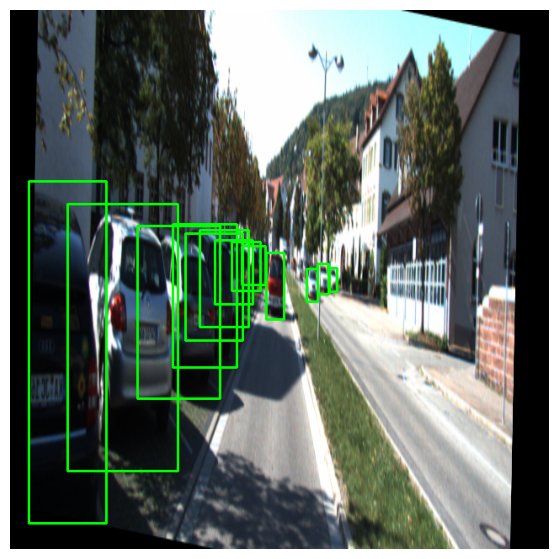

In [ ]:
#Check one batch visually

import matplotlib.pyplot as plt

def show_batch(dataset, idx=0):
    img, tgt = dataset[idx]
    img_np = img.permute(1,2,0).cpu().numpy()
    img_np = (img_np * np.array([0.229,0.224,0.225]) +
              np.array([0.485,0.456,0.406]))
    img_np = np.clip(img_np, 0, 1)

    for box in tgt["boxes"]:
        x1,y1,x2,y2 = box
        cv2.rectangle(img_np, (int(x1),int(y1)), (int(x2),int(y2)), (0,1,0), 2)

    plt.figure(figsize=(7,7))
    plt.imshow(img_np)
    plt.axis("off")

show_batch(train_dataset, 0)


# RetinaNet Fine-Tuning on KITTI

In [ ]:
import torch
import torchvision
from torchvision.models.detection.retinanet import RetinaNet_ResNet50_FPN_Weights
from torchvision.models.detection.retinanet import RetinaNetClassificationHead

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Load COCO-pretrained RetinaNet
model = torchvision.models.detection.retinanet_resnet50_fpn(
    weights=RetinaNet_ResNet50_FPN_Weights.DEFAULT
)

# ============================
#   CORRECT HEAD REPLACEMENT
# ============================

num_classes = 4  # background + Car + Pedestrian + Cyclist

# Backbone output channels (correct way)
in_channels = model.backbone.out_channels

# Number of anchors for RetinaNet = usually 9
num_anchors = model.head.classification_head.num_anchors

# Create new classification head
model.head.classification_head = RetinaNetClassificationHead(
    in_channels=in_channels,
    num_anchors=num_anchors,
    num_classes=num_classes
)

model = model.to(device)


Device: cuda


In [ ]:
#Training Loop (Full)
def train_one_epoch(model, optimizer, dataloader, device, epoch):
    model.train()
    total_loss = 0

    for images, targets in dataloader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k,v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()

    return total_loss / len(dataloader)


In [ ]:
#Validation Loop
def validate(model, dataloader, device):
    model.eval()
    with torch.no_grad():
        for images, targets in dataloader:
            images = [img.to(device) for img in images]
            outputs = model(images)
    return True



In [ ]:
#Training Script
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)


num_epochs = 10
save_path = "/content/drive/My Drive/Colab Notebooks/CV Project/trained_models/retinanet_kitti.pth"
os.makedirs(os.path.dirname(save_path), exist_ok=True)

for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, optimizer, train_loader, device, epoch)
    print(f"Epoch {epoch+1}/{num_epochs}  Train Loss: {train_loss:.4f}")

    validate(model, val_loader, device)

# save weights
torch.save(model.state_dict(), save_path)
print("Model saved:", save_path)


Epoch 1/10  Train Loss: 0.7854
Epoch 2/10  Train Loss: 0.5698
Epoch 3/10  Train Loss: 0.4586
Epoch 4/10  Train Loss: 0.4459
Epoch 5/10  Train Loss: 0.4051
Epoch 6/10  Train Loss: 0.3932
Epoch 7/10  Train Loss: 0.3670
Epoch 8/10  Train Loss: 0.3520
Epoch 9/10  Train Loss: 0.3430
Epoch 10/10  Train Loss: 0.3288
Model saved: /content/drive/My Drive/Colab Notebooks/CV Project/trained_models/retinanet_kitti.pth


In [ ]:
model.eval()
img_path = IMAGE_DIR + "/" + train_files[0]

img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

transformed = val_transform(image=img_rgb, bboxes=[], labels=[])
input_tensor = transformed["image"].to(device)

with torch.no_grad():
    output = model([input_tensor])[0]

output


{'boxes': tensor([[306.3359, 298.3817, 328.9921, 372.7044],
         [394.0595, 293.8365, 499.4944, 480.8525],
         [446.0959, 280.3941, 583.8091, 558.5735],
         [363.7229, 293.5179, 442.6433, 413.4929],
         [348.8271, 294.2650, 398.9655, 365.7291],
         [420.9644, 291.0585, 539.5740, 508.0995],
         [339.7286, 296.6570, 384.5363, 353.5593],
         [540.6093, 296.3174, 639.3743, 631.7313],
         [354.0085, 297.4922, 420.2599, 386.5151],
         [370.1702, 283.7829, 473.5531, 447.4007],
         [246.2197, 298.1428, 261.7949, 334.4133],
         [260.9948, 306.0170, 276.3576, 344.3662],
         [334.1440, 298.3387, 369.3057, 342.4055],
         [331.0377, 296.2175, 354.5283, 335.7570],
         [546.8094, 283.4198, 634.5859, 486.9901],
         [496.0721, 284.2191, 628.1243, 539.8171],
         [253.6975, 303.1173, 272.1248, 339.8673],
         [325.7581, 294.1984, 340.5147, 333.2662],
         [319.8355, 296.3391, 332.9514, 343.4234],
         [236.7625, 29

# Faster RCNN

In [ ]:
#Import & Prepare
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FasterRCNN_ResNet50_FPN_Weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

#Load Pretrained Faster R-CNN (COCO)

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
    weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT
)
#


#Replace Classification Head

num_classes = 4  # background + Car + Pedestrian + Cyclist

in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(
    in_features,
    num_classes
)



model = model.to(device)


#Optimizer
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)



Device: cuda
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:00<00:00, 241MB/s]


In [ ]:
#Training Loop
def train_one_epoch_frcnn(model, optimizer, dataloader, device, epoch):
    model.train()
    total_loss = 0

    for images, targets in dataloader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k,v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        loss = sum(loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


In [ ]:
#Validation Loop

def validate_frcnn(model, dataloader, device):
    model.eval()
    with torch.no_grad():
        for images, targets in dataloader:
            images = [img.to(device) for img in images]
            outputs = model(images)
    return True


In [ ]:
#Training Script
num_epochs = 10
save_path = "/content/drive/My Drive/Colab Notebooks/CV Project/trained_models/fasterrcnn_kitti.pth"
os.makedirs(os.path.dirname(save_path), exist_ok=True)

for epoch in range(num_epochs):
    train_loss = train_one_epoch_frcnn(model, optimizer, train_loader, device, epoch)
    print(f"Epoch {epoch+1}/{num_epochs}  Train Loss: {train_loss:.4f}")

    validate_frcnn(model, val_loader, device)

# save final weights
torch.save(model.state_dict(), save_path)
print("Model saved:", save_path)


Epoch 1/10  Train Loss: 0.4526
Epoch 2/10  Train Loss: 0.3650
Epoch 3/10  Train Loss: 0.3447
Epoch 4/10  Train Loss: 0.3311
Epoch 5/10  Train Loss: 0.3135
Epoch 6/10  Train Loss: 0.3051
Epoch 7/10  Train Loss: 0.3039
Epoch 8/10  Train Loss: 0.2942
Epoch 9/10  Train Loss: 0.2886
Epoch 10/10  Train Loss: 0.2862
Model saved: /content/drive/My Drive/Colab Notebooks/CV Project/trained_models/fasterrcnn_kitti.pth


In [ ]:
#Inference Test

model.eval()

img_path = IMAGE_DIR + "/" + val_files[0]
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

transformed = val_transform(image=img_rgb, bboxes=[], labels=[])
input_tensor = transformed["image"].to(device)

with torch.no_grad():
    output = model([input_tensor])[0]

output


{'boxes': tensor([[169.9416, 292.1960, 205.8727, 350.2498],
         [195.5404, 298.6146, 263.5344, 383.3190],
         [  8.1217, 298.3207, 120.1259, 421.3646],
         [289.1660, 286.1711, 308.8793, 337.2871],
         [286.7735, 289.1750, 301.8999, 327.5154],
         [332.5935, 296.7278, 340.6177, 343.3868],
         [296.0644, 285.9004, 311.8109, 327.6547],
         [332.8753, 296.3629, 342.2790, 344.0030],
         [197.1959, 299.6893, 229.4924, 343.7425],
         [346.9450, 288.1844, 355.0611, 359.8690],
         [  0.5071, 292.9176,  17.5894, 494.7378],
         [312.5383, 288.1695, 326.7333, 320.6330],
         [  3.7027, 286.6285,  61.5346, 393.4964],
         [335.7090, 296.6710, 342.4392, 344.7678],
         [302.1086, 288.1674, 313.7640, 321.6859],
         [346.2619, 289.4330, 354.5311, 358.1950],
         [ 35.5710, 311.1034, 114.6180, 396.8660]], device='cuda:0'),
 'labels': tensor([1, 1, 1, 1, 1, 2, 1, 3, 1, 2, 1, 1, 1, 2, 1, 3, 1], device='cuda:0'),
 'scores': tenso

# Mask R-CNN

In [ ]:
import torch
import torchvision
from torchvision.models.detection.mask_rcnn import MaskRCNN_ResNet50_FPN_Weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


#Load the Pretrained Mask R-CNN
model = torchvision.models.detection.maskrcnn_resnet50_fpn(
    weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT
)


# ==== ONLY BBOX DETECTION ====
model.roi_heads.mask_roi_pool = None
model.roi_heads.mask_head = None
model.roi_heads.mask_predictor = None

num_classes = 4  # background + Car + Pedestrian + Cyclist

# box predictor
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(
    in_features,
    num_classes
)



model = model.to(device)


optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)


Device: cuda


In [ ]:
#Training Loop
def train_one_epoch_maskrcnn(model, optimizer, dataloader, device, epoch):
    model.train()
    total_loss = 0

    for images, targets in dataloader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k,v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        loss = sum(loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


In [ ]:
#Validation Loop
def validate_maskrcnn(model, dataloader, device):
    model.eval()
    with torch.no_grad():
        for images, targets in dataloader:
            images = [img.to(device) for img in images]
            outputs = model(images)
    return True


In [ ]:
#Training Script

num_epochs = 10
save_path = "/content/drive/My Drive/Colab Notebooks/CV Project/trained_models/maskrcnn_kitti.pth"
os.makedirs(os.path.dirname(save_path), exist_ok=True)

for epoch in range(num_epochs):
    train_loss = train_one_epoch_maskrcnn(model, optimizer, train_loader, device, epoch)
    print(f"Epoch {epoch+1}/{num_epochs}  Train Loss: {train_loss:.4f}")

    validate_maskrcnn(model, val_loader, device)

# SAVE
torch.save(model.state_dict(), save_path)
print("Model saved:", save_path)


Epoch 1/10  Train Loss: 0.4487
Epoch 2/10  Train Loss: 0.3630
Epoch 3/10  Train Loss: 0.3419
Epoch 4/10  Train Loss: 0.3217
Epoch 5/10  Train Loss: 0.3093
Epoch 6/10  Train Loss: 0.3038
Epoch 7/10  Train Loss: 0.2978
Epoch 8/10  Train Loss: 0.2870
Epoch 9/10  Train Loss: 0.2834
Epoch 10/10  Train Loss: 0.2789
Model saved: /content/drive/My Drive/Colab Notebooks/CV Project/trained_models/maskrcnn_kitti.pth


In [ ]:

#Inference Test
model.eval()

img_path = IMAGE_DIR + "/" + val_files[5]
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

transformed = val_transform(image=img_rgb, bboxes=[], labels=[])
input_tensor = transformed["image"].to(device)

with torch.no_grad():
    output = model([input_tensor])[0]

output


{'boxes': tensor([[165.0406, 320.2325, 201.8620, 382.4116],
         [308.2990, 302.4209, 323.2118, 348.1146],
         [130.3467, 316.5305, 138.2657, 367.8068],
         [390.5704, 292.8354, 411.8459, 416.0284],
         [ 85.6666, 306.7248,  93.8923, 369.6557],
         [400.3806, 293.6614, 409.3687, 363.4956],
         [394.0623, 287.1776, 409.9359, 413.7745],
         [253.1778, 308.2373, 264.5270, 334.9965],
         [127.7215, 314.6606, 135.1137, 377.6458],
         [106.3572, 313.4555, 112.3013, 357.1165],
         [126.3922, 315.2832, 139.8661, 379.1497],
         [ 84.3245, 306.7302,  96.7326, 386.1630]], device='cuda:0'),
 'labels': tensor([1, 1, 2, 3, 2, 2, 2, 1, 2, 2, 3, 3], device='cuda:0'),
 'scores': tensor([0.9990, 0.9979, 0.8172, 0.5637, 0.4048, 0.3224, 0.3053, 0.2141, 0.1470, 0.1116, 0.1058, 0.0527], device='cuda:0')}